# Analysis of UK fishing data from 2008 to 2015

In this jupyter notebook a data set containing information about commercial fishing catches is analysed. The used data set is described and prepared at first. The subsequent analysis outlines the following theses:

1. The amount of demersal fish delivered to UK ports by vessels shorter than 10 Meters is never greater than 2000 tonnes per year. Larger vessels rarely deliver more than 12,000, tonnes a year.
2. The respective maximum values of fishing catches per year are ca. 5 Million GBP for vessels shorter than 10m and ca. 14 Million GBP for larger vessels.
3. There is a correlation between the weight of a catch and it's monetary value. The heavier the catch, the more valuable. This is true until a certain point, after which a heavier catch gets less valuable in comparison.
4. Most demersal species are caught in the warmer seasons.
5. The turnover for fishing catches of larger vessels is rising, while the turnover for smaller vessels is decreasing. Fishing vessels below 10 Meters tend to be less involved in commercial fishing in the UK.
6. English and Scottish vessels are the main contributor to commercial fishing in the UK. However, while the volume of English vessels is rising, Scottish vessels tend to be involved less.
7. Catches of vessels that are not of English nationality are valued more than Scottish catches.

In [630]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
%matplotlib inline

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 0.24.1
Numpy Version: 1.16.2
Seaborn Version: 0.9.0


## Data Set description

This notebook is a data analysis of the kaggle data set ["UK fleet and foreign fleet landings by port"](https://www.kaggle.com/theflyingmunkey/uk-fleet-landings). The data set is created from a data series of the [UK fleet landings and foreign fleet landings into the UK by port](https://www.gov.uk/government/statistical-data-sets/uk-fleet-landings-and-foreign-fleet-landings-into-the-uk-by-port) by joining multiple CSV files together. This results in a table of 672,256 entries which contains information about commercial fishing in the UK. Each row of the table contains information about a fishing catch. Columns relevant for this notebook are:

* `year`: The year of landing, ranges from 2008 to 2015
* `month`: The month of landing, ranges from 1 to 12
* `vessel_nationality`: The nationality of the vessel which landed the catch
* `length_group`: The vessel's length group, either "10m or under" or "Over 10m"
* `species_group`: The general species of the catch, either "Demersal", "Pelagic" or "Shellfish"
* `landed_weight`: Weight of the catch on land in tonnes
* `value_gbp`: Value of the catch in GBP, "most likely without any inflation adjustment"

### Additional domain information

**Pelagic** fish live in the pelagic zone of ocean or lake waters – being neither close to the bottom nor to the shore – contrary to **demersal** fish, which live on or near the bottom, and reef fish, which are associated with coral reefs. **Shellfish** examples are shells, oysters, clams and scallops.

In [631]:
# Read data from the original csv file
original_data = pd.read_csv("data/UK_fleet_landings.csv")
original_data.sample(6)

,year,month,port_of_landing,port_nationality,vessel_nationality,length_group,gear_category,species_code,species_name,species,species_group,live_weight,landed_weight,value_gbp
628821,2008,5,Peterhead,UK - Scotland,UK - Scotland,Over 10m,Demersal trawl/seine,-,-,Other demersal,Demersal,44.8214,39.6368,60706.98
323400,2012,11,Dunmore East,Ireland,UK - Northern Ireland,Over 10m,Demersal trawl/seine,RJM,Spotted Ray,Skates and Rays,Demersal,0.8150,0.7210,1088.50
267361,2012,4,Brixham,UK - England,UK - England,Over 10m,Beam trawl,WEG,Greater Weever,Other Demersal,Demersal,0.0030,0.0030,2.60
261887,2012,3,Lochinver,UK - Scotland,France,10m and under,Demersal trawl/seine,DAB,Dabs,Dabs,Demersal,0.2760,0.2490,131.24
81674,2014,1,Grimsby,UK - England,UK - England,Over 10m,Demersal trawl/seine,WHG,Whiting,Whiting,Demersal,0.4910,0.4860,380.99
123794,2014,7,Peterhead,UK - Scotland,Norway,Over 10m,Demersal trawl/seine,TUR,Turbot,Turbot,Demersal,0.1820,0.1670,1422.01


## Constants

In [632]:
# for uniform plot sizes
SMALL_CHART = (9,5)
MEDIUM_CHART = (11,8)
LARGE_CHART = (13,9)

# Data preparation

## Removing null and negative values

In [633]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672256 entries, 0 to 672255
Data columns (total 14 columns):
year                  672256 non-null int64
month                 672256 non-null int64
port_of_landing       672256 non-null object
port_nationality      672256 non-null object
vessel_nationality    672256 non-null object
length_group          672256 non-null object
gear_category         672256 non-null object
species_code          672256 non-null object
species_name          672256 non-null object
species               672256 non-null object
species_group         672239 non-null object
live_weight           672256 non-null float64
landed_weight         672256 non-null float64
value_gbp             672256 non-null float64
dtypes: float64(3), int64(2), object(9)
memory usage: 71.8+ MB


The `info()` method shows that almost no NA values (`None`, `NaN` or `NaT`) are contained in the original data set. Only 17 rows are missing values for `species_group`. These entries should be cleaned up to avoid computation errors.

In [634]:
original_data[original_data.isnull().any(axis=1)] # returns all rows with a NA value

,year,month,port_of_landing,port_nationality,vessel_nationality,length_group,gear_category,species_code,species_name,species,species_group,live_weight,landed_weight,value_gbp
30729,2015,5,Scrabster,UK - Scotland,UK - England,Over 10m,Drift and fixed nets,UKN,Unknown,Other,NaN,0.000,6.755,0.00
155333,2014,12,Brixham,UK - England,UK - England,Over 10m,Beam trawl,ZZB,Tongues,Other,NaN,0.000,0.186,0.00
173341,2013,3,Boulogne,France,UK - Scotland,Over 10m,Demersal trawl/seine,UKN,Unknown,Other,NaN,0.006,0.006,46.15
181144,2013,4,Isle Of Wight,UK - England,UK - England,10m and under,Drift and fixed nets,MAS,Chub Mackerel,Other,NaN,0.000,0.000,0.60
186279,2013,5,Boulogne,France,UK - Scotland,Over 10m,Demersal trawl/seine,UKN,Unknown,Other,NaN,0.010,0.010,109.74
193740,2013,6,Boulogne,France,UK - Scotland,Over 10m,Demersal trawl/seine,UKN,Unknown,Other,NaN,0.097,0.097,904.45
233780,2013,11,Gourdon,UK - Scotland,UK - Scotland,Over 10m,Demersal trawl/seine,UKN,Unknown,Other,NaN,0.001,0.001,2.53
288157,2012,6,Scrabster,UK - Scotland,Faeroe Islands,10m and under,Demersal trawl/seine,UKN,Unknown,Other,NaN,0.350,0.350,1736.77
347095,2011,2,Scrabster,UK - Scotland,Faeroe Islands,10m and under,Demersal trawl/seine,UKN,Unknown,Other,NaN,0.104,0.104,112.81
369778,2011,5,Scheveningen,Netherlands,UK - England,Over 10m,Demersal trawl/seine,MAS,Chub Mackerel,Other,NaN,1.176,1.176,323.40


Missing data in the `species_group` column arose from missing values in the original `.csv` file. For example, the entry at index 30729 looks like this:

```
2015,5,Scrabster,UK - Scotland,UK - England,Over 10m,Drift and fixed nets,UKN,Unknown,Other,,0,6.755,0
```

It seems that the species for the respective entries could not be defined with certainty, so we replace the NA values with `Unknown`.

In [635]:
data = original_data.fillna({'species_group': 'Unknown'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672256 entries, 0 to 672255
Data columns (total 14 columns):
year                  672256 non-null int64
month                 672256 non-null int64
port_of_landing       672256 non-null object
port_nationality      672256 non-null object
vessel_nationality    672256 non-null object
length_group          672256 non-null object
gear_category         672256 non-null object
species_code          672256 non-null object
species_name          672256 non-null object
species               672256 non-null object
species_group         672256 non-null object
live_weight           672256 non-null float64
landed_weight         672256 non-null float64
value_gbp             672256 non-null float64
dtypes: float64(3), int64(2), object(9)
memory usage: 71.8+ MB


Entries about unknown species will not be of interest to us because we can't match it. We will remove data rows where the `species_group` value equals `"Unknown"`.

In [636]:
clean_data = data[data.species_group != "Unknown"]
print("Removed", original_data.shape[0] - clean_data.shape[0], "entries")

Removed 17 entries


In [637]:
clean_data.describe()

,year,month,live_weight,landed_weight,value_gbp
count,672239.000000,672239.000000,672239.000000,672239.000000,6.722390e+05
mean,2011.517802,6.582919,8.605618,8.068051,9.999343e+03
std,2.221115,3.334999,169.053452,168.114609,1.376510e+05
min,2008.000000,1.000000,-0.020000,-0.020000,-1.979290e+03
25%,2010.000000,4.000000,0.013300,0.012000,2.437000e+01
50%,2011.000000,7.000000,0.098000,0.089000,1.966500e+02
75%,2013.000000,9.000000,0.761100,0.691000,1.687630e+03
max,2015.000000,12.000000,32942.735000,32942.735000,2.894126e+07


The `describe()` method shows that there are some entries with negative values in the `landed_weight` and `value_gbp` columns, which we will also remove.

In [638]:
clean_data_tmp = clean_data.copy()
clean_data_tmp = clean_data_tmp.drop(clean_data_tmp[clean_data_tmp.landed_weight < 0].index)
clean_data_tmp = clean_data_tmp.drop(clean_data_tmp[clean_data_tmp.value_gbp < 0].index)
print("Removed", clean_data.shape[0] - clean_data_tmp.shape[0], "entries")
clean_data = clean_data_tmp

Removed 6 entries


In [639]:
clean_data.describe()

,year,month,live_weight,landed_weight,value_gbp
count,672233.000000,672233.000000,672233.000000,672233.000000,6.722330e+05
mean,2011.517771,6.582915,8.605694,8.068122,9.999435e+03
std,2.221101,3.335011,169.054204,168.115357,1.376516e+05
min,2008.000000,1.000000,0.000000,0.000000,0.000000e+00
25%,2010.000000,4.000000,0.013300,0.012000,2.437000e+01
50%,2011.000000,7.000000,0.098000,0.089000,1.966500e+02
75%,2013.000000,9.000000,0.761100,0.691000,1.687680e+03
max,2015.000000,12.000000,32942.735000,32942.735000,2.894126e+07


## Select focus data

To make analysing the data more manageable, we want to focus on only one of the three species groups. We will choose the "Demersal" species, for which there are the most data entries. We will also select only the columns which are relevant to the subsequent data analysis.

In [640]:
print("'Demersal' species entries: ", clean_data[clean_data.species_group == "Demersal"].shape[0])
print("'Pelagic' species entries: ", clean_data[clean_data.species_group == "Pelagic"].shape[0])
print("'Shellfish' species entries: ", clean_data[clean_data.species_group == "Shellfish"].shape[0])

'Demersal' species entries:  435480
'Pelagic' species entries:  26833
'Shellfish' species entries:  209920


In [641]:
target_data = clean_data[[
    "year",
    "month",
    "vessel_nationality",
    "species_group",
    "landed_weight",
    "value_gbp",
    "length_group"
]].groupby("species_group")
target_data = target_data.get_group("Demersal")
target_data.name = "Demersal Catches"

In [642]:
target_data.head(6)

,year,month,vessel_nationality,species_group,landed_weight,value_gbp,length_group
0,2015,1,UK - Wales,Demersal,0.005,27.6,10m and under
1,2015,1,UK - Wales,Demersal,0.001,3.3,10m and under
5,2015,1,UK - Scotland,Demersal,0.020,124.0,Over 10m
8,2015,1,UK - Scotland,Demersal,0.018,36.0,Over 10m
24,2015,1,UK - England,Demersal,0.118,354.0,10m and under
25,2015,1,UK - England,Demersal,0.072,144.0,10m and under


## Analyse outliers and aggregate data

With negative and null values removed, we can now look at the outlier entries. The `describe` method gives us a first idea about the shape of the numeric values.

In [643]:
target_data.describe()

,year,month,landed_weight,value_gbp
count,435480.000000,435480.000000,435480.000000,4.354800e+05
mean,2011.501575,6.511716,3.091063,6.016602e+03
std,2.209975,3.350284,32.124577,4.778701e+04
min,2008.000000,1.000000,0.000000,0.000000e+00
25%,2010.000000,4.000000,0.008300,1.550000e+01
50%,2011.000000,7.000000,0.052000,1.041350e+02
75%,2013.000000,9.000000,0.371000,7.617500e+02
max,2015.000000,12.000000,5215.127000,2.526718e+06


When looking at the info for `landed_weight` and `value_gbp` we notice that the values seem to differ immensely. For example, the mean value for `landed_weight` is around 3, although the maximum value is around 5200. The standard deviation is 32, which is very high. It seems that there are a few outlier entries with relatively high values for both of these columns. This could cause trouble when analyzing the data because a few high values can cause distortions. This becomes apparent when we try to generate a histogram, showing the distribution of demersal `landed_weight` entries.

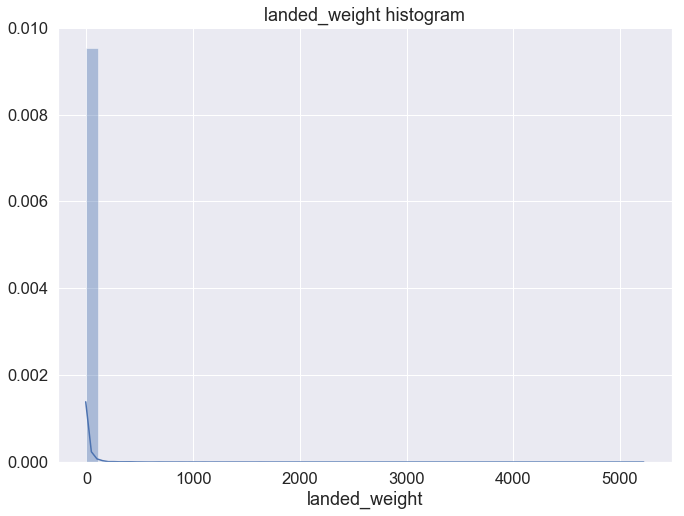

In [644]:
plt.figure(figsize=(MEDIUM_CHART))
plt.title("landed_weight histogram")
sns.distplot(target_data["landed_weight"])

The histogram suggest that most values are close to or equal to 0, with a few very large values distorting the scale. We can restrict the histograms to the 75th percentile to get an idea of the data range where 25% of the largest values are removed.

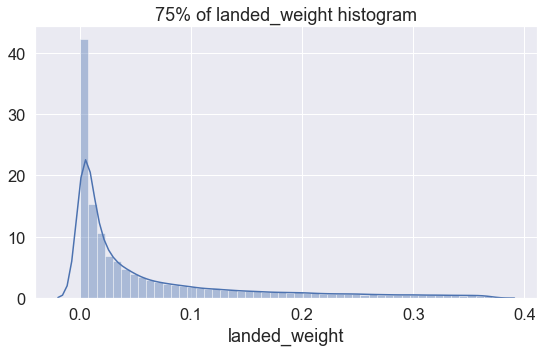

In [645]:
q3 = target_data.landed_weight.quantile(0.75)
df = target_data[target_data.landed_weight.between(0, q3)]
plt.figure(figsize=(SMALL_CHART))
plt.title("75% of landed_weight histogram")
sns.distplot(df["landed_weight"])

We can see that the plotted `landed_weight` range has changed drastically from a max value of 5000t to 0.4t. This can be repeated for the `value_gbp` values, where the scale changes from 2,500,000£ to 800£.

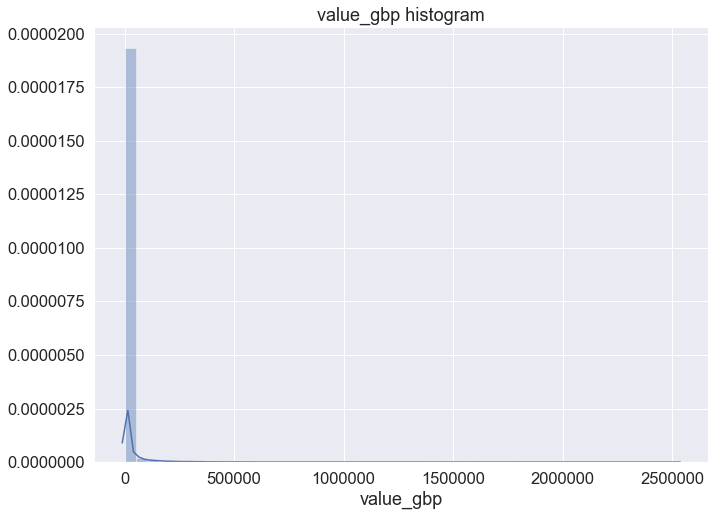

In [646]:
plt.figure(figsize=(MEDIUM_CHART))
plt.title("value_gbp histogram")
sns.distplot(target_data["value_gbp"])

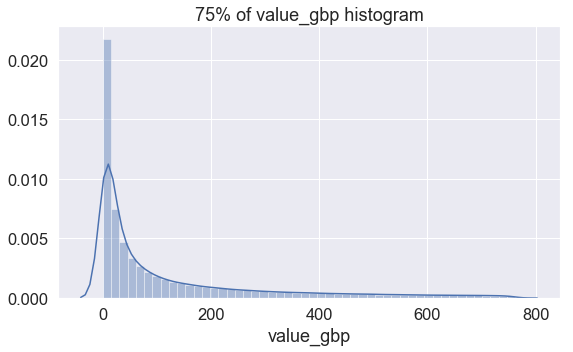

In [647]:
q3 = target_data.value_gbp.quantile(0.75)
df = target_data[target_data.value_gbp.between(0, q3)]
plt.figure(figsize=(SMALL_CHART))
plt.title("75% of value_gbp histogram")
sns.distplot(df["value_gbp"])

This already tells us that 75% of the catches of demersal fish were quoted with a landed weight of under or equal to 0.4 tons (or 400 kg) and/or valued at below or equal to 800£. We can identify which data rows are the highest 25%.

In [648]:
x = target_data[target_data.landed_weight > 0.4]
y = target_data[target_data.value_gbp > 800]
z = target_data.shape[0]

print("{} of {} entries have a landed_weight of > 0.4.".format(x.shape[0] ,z))
print("{} of {} entries have a value_gbp of > 800.".format(y.shape[0] ,z))

105233 of 435480 entries have a landed_weight of > 0.4.
106585 of 435480 entries have a value_gbp of > 800.


The data set contains a lot of small values because the nature of the entries is very detailed. All catches are split by several features, for example the port of landing, vessel nationality, species and subspecies. Especially splitting the catches by subspecies leads to multiple entries of smaller weight and value if different species are caught. We can demonstrate this with the following example, fetching all demersal catch entries noted at Blyth in January 2015 and sorting them by `value_gbp`. We can see that there are several entries for Cod, Whiting, Sole or Ling respectively.

In [649]:
original_data[
    (original_data.year == 2015) &
    (original_data.month == 1) &
    (original_data.port_of_landing == "Blyth") &
    (original_data.species_group == "Demersal")
].sort_values(by="value_gbp", ascending=False)

,year,month,port_of_landing,port_nationality,vessel_nationality,length_group,gear_category,species_code,species_name,species,species_group,live_weight,landed_weight,value_gbp
267,2015,1,Blyth,UK - England,UK - England,10m and under,Demersal trawl/seine,WHG,Whiting,Whiting,Demersal,9.945,9.945,7890.37
248,2015,1,Blyth,UK - England,UK - England,10m and under,Demersal trawl/seine,COD,Cod,Cod,Demersal,5.292,4.527,4640.79
293,2015,1,Blyth,UK - England,UK - England,Over 10m,Demersal trawl/seine,WHG,Whiting,Whiting,Demersal,4.540,4.470,4545.30
321,2015,1,Blyth,UK - England,UK - Scotland,Over 10m,Demersal trawl/seine,WHG,Whiting,Whiting,Demersal,3.980,3.955,4177.20
301,2015,1,Blyth,UK - England,UK - Scotland,Over 10m,Demersal trawl/seine,ANF,Monks or Anglers,Monks or Anglers,Demersal,1.415,1.172,2560.34
283,2015,1,Blyth,UK - England,UK - England,Over 10m,Demersal trawl/seine,ANF,Monks or Anglers,Monks or Anglers,Demersal,0.645,0.532,1568.50
285,2015,1,Blyth,UK - England,UK - England,Over 10m,Demersal trawl/seine,HAD,Haddock,Haddock,Demersal,0.550,0.470,962.06
284,2015,1,Blyth,UK - England,UK - England,Over 10m,Demersal trawl/seine,COD,Cod,Cod,Demersal,0.710,0.607,742.57
307,2015,1,Blyth,UK - England,UK - Scotland,Over 10m,Demersal trawl/seine,HAD,Haddock,Haddock,Demersal,0.513,0.439,666.25
271,2015,1,Blyth,UK - England,UK - England,10m and under,Pots and traps,COD,Cod,Cod,Demersal,0.671,0.574,612.90


Since we do not want to analyse this data set on a subspecies level we will aggregate the values while keeping the separation by date, vessel nationality, vessel length and species group.

In [650]:
df = target_data.groupby([
    "year",
    "month",
    "vessel_nationality",
    "species_group",
    "length_group"
], as_index=False).sum()

In [651]:
# Reset and rename index for better handling.
df.reset_index(drop=True, inplace=True)
df.index.name = "index"
df.reset_index(inplace=True)

In [652]:
df.head(8)

,index,year,month,vessel_nationality,species_group,length_group,landed_weight,value_gbp
0,0,2008,1,Belgium,Demersal,10m and under,70.9929,296955.22
1,1,2008,1,Belgium,Demersal,Over 10m,218.7558,607841.09
2,2,2008,1,Denmark,Demersal,10m and under,3.9915,8658.27
3,3,2008,1,Denmark,Demersal,Over 10m,0.1500,199.41
4,4,2008,1,Faeroe Islands,Demersal,10m and under,306.8124,378710.77
5,5,2008,1,Faeroe Islands,Demersal,Over 10m,102.8320,65800.68
6,6,2008,1,France,Demersal,10m and under,689.8888,519548.32
7,7,2008,1,France,Demersal,Over 10m,160.2296,171280.46


In [653]:
df.tail(8)

,index,year,month,vessel_nationality,species_group,length_group,landed_weight,value_gbp
2085,2085,2015,12,UK - England,Demersal,Over 10m,2963.243,9403982.54
2086,2086,2015,12,UK - Guernsey,Demersal,Over 10m,5.783,20942.01
2087,2087,2015,12,UK - Jersey,Demersal,Over 10m,3.435,13414.00
2088,2088,2015,12,UK - Northern Ireland,Demersal,Over 10m,95.033,130293.76
2089,2089,2015,12,UK - Scotland,Demersal,10m and under,1.377,6188.72
2090,2090,2015,12,UK - Scotland,Demersal,Over 10m,5056.045,12214671.24
2091,2091,2015,12,UK - Wales,Demersal,10m and under,7.097,5648.38
2092,2092,2015,12,UK - Wales,Demersal,Over 10m,45.044,233468.31


In [654]:
df.describe()

,index,year,month,landed_weight,value_gbp
count,2093.000000,2093.000000,2093.000000,2093.000000,2.093000e+03
mean,1046.000000,2011.418060,6.511706,643.141916,1.251844e+06
std,604.341377,2.306902,3.415811,1687.271259,3.054124e+06
min,0.000000,2008.000000,1.000000,0.006000,0.000000e+00
25%,523.000000,2009.000000,4.000000,5.195700,7.884890e+03
50%,1046.000000,2011.000000,7.000000,48.911000,1.203300e+05
75%,1569.000000,2013.000000,9.000000,300.639400,6.554853e+05
max,2092.000000,2015.000000,12.000000,11997.866000,1.484370e+07


As we can see with `describe()`, the standard deviation got larger and there are still great differences between the min and max values. However, we have significantly reduced the number of entries and can now analyse demersal catches data regardless of subspecies.

# Data analysis

After the data set is cleaned and the focus on demersal species catches is set we will analyse the data. Visualising data with libraries like `matplotlib` and `seaborn` will make it easier to discover connections and draw conclusions.

## Splitting data by vessel length

In this sections the entries are split by `length_group` which divides the data set into two groups: shipping vessels with a length shorter or equal to 10m ("10m and under") and shipping vessels that are longer than 10m ("Over 10m"). Both resulting groups are then compared, focusing on the weight and monetary value of fishing catches.

The following plots display a dot for each entry in the `landed_weight` and `value_gbp` column. Blue dots resemble entries of smaller vessels, orange dots of larger vessels.

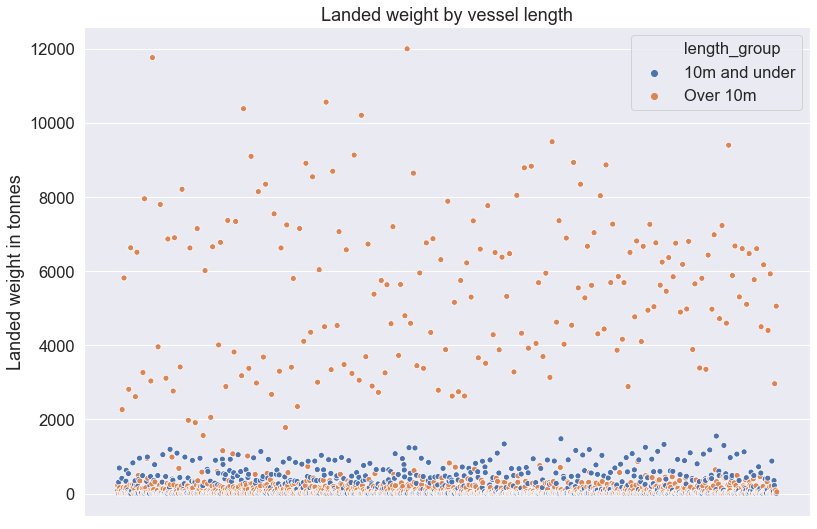

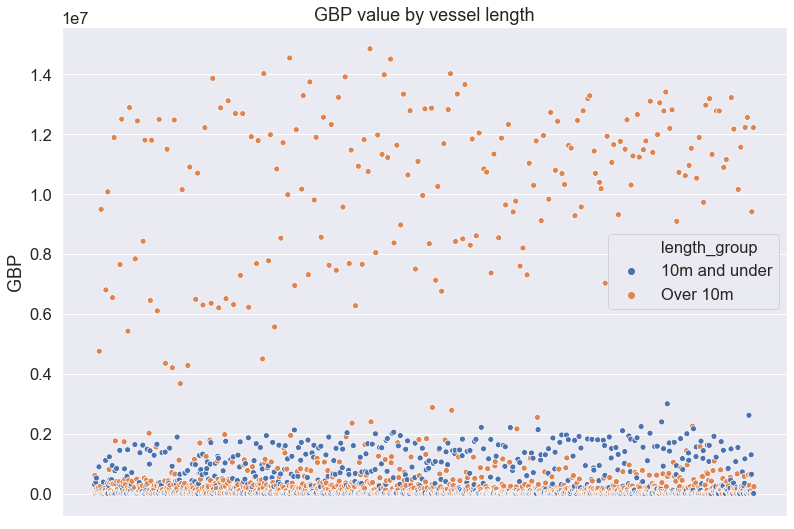

In [655]:
plt.figure(figsize=(LARGE_CHART))
plt.title("Landed weight by vessel length")
ax = sns.scatterplot(x="index", y="landed_weight", data=df, hue="length_group")
ax.get_xaxis().set_visible(False)
ax.set(ylabel="Landed weight in tonnes")
plt.show()

plt.figure(figsize=(LARGE_CHART))
plt.title("GBP value by vessel length")
ax = sns.scatterplot(x="index", y="value_gbp", data=df, hue="length_group")
ax.get_xaxis().set_visible(False)
ax.set(ylabel="GBP")
plt.show()

This illustrates that the amount of demersal fish caught by smaller vessels (per month) has never been greater than 2,000 tonnes between 2008 and 2015. It also shows that it is possible for longer vessels to catch larger amount of fish, with the highest amount just above 12,000 tonnes. However, this is not the case for most large vessel catches, which seem be to below 2,000 tonnes as well. In addition, the transition from catches below and above 2,000 tonnes does not seem to be steady, as there is a distinct gap around the Y value of 2,000. The plot for GBP values looks very similar, with an upper bound for small vessels at around 5 Million GBP and a maximum value of 14 Million GBP. A larger gap can be seen here as well.

This gap is caused by an additional separation by vessel nationality. The following plots are similar to the prior plots, but the dots are coloured by vessel nationality.

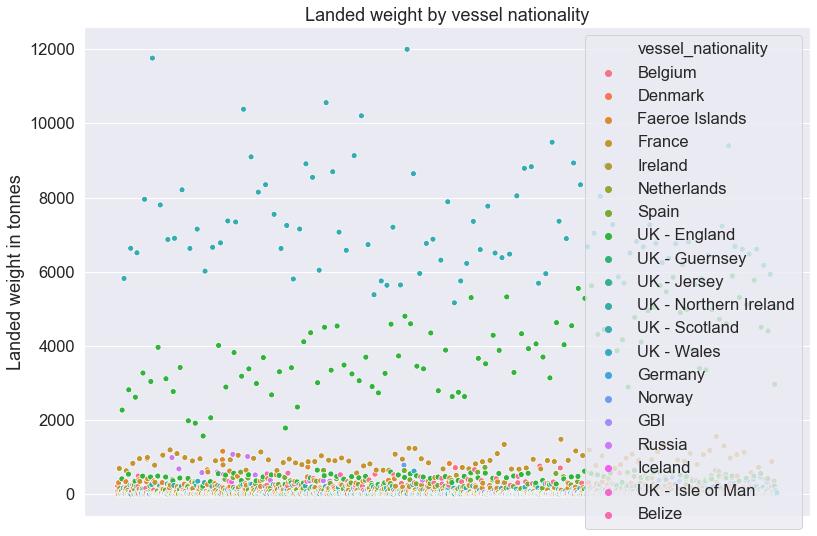

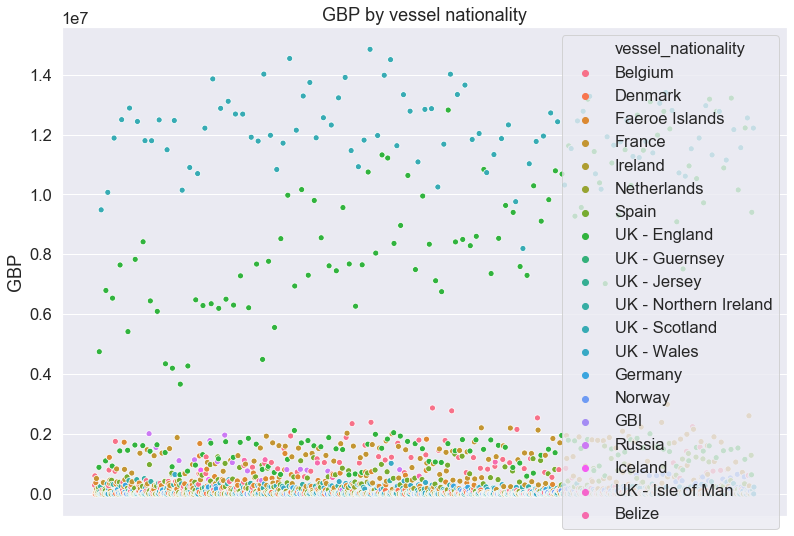

In [656]:
plt.figure(figsize=(LARGE_CHART))
plt.title("Landed weight by vessel nationality")
ax = sns.scatterplot(x="index", y="landed_weight", data=df, hue="vessel_nationality")
ax.get_xaxis().set_visible(False)
ax.set(ylabel="Landed weight in tonnes")
plt.show()

plt.figure(figsize=(LARGE_CHART))
plt.title("GBP by vessel nationality")
ax = sns.scatterplot(x="index", y="value_gbp", data=df, hue="vessel_nationality")
ax.get_xaxis().set_visible(False)
ax.set(ylabel="GBP")
plt.show()

Because the colors almost form a gradient it is apparent that certain nationalities are more dominant in the British commercial fishing industry. Scotland, Ireland and England appear to contribute the most. A more detailed analysation of vessel nationality data could be interesting and will follow at a later point.

To analyse vessel length data regardless of vessel nationality we will sum up the values by year, month and vessel length.

In [657]:
df_a = df.groupby(["year", "month", "length_group"], as_index=False).sum().drop(columns=["index"])
df_a.reset_index(drop=True, inplace=True)
df_a.index.name = "index"
df_a.reset_index(inplace=True)
df_a.head(6)

,index,year,month,length_group,landed_weight,value_gbp
0,0,2008,1,10m and under,1590.1249,2297503.08
1,1,2008,1,Over 10m,8869.9716,15783150.76
2,2,2008,2,10m and under,1638.1370,2192887.41
3,3,2008,2,Over 10m,10165.1966,18170591.63
4,4,2008,3,10m and under,2315.2534,3376183.33
5,5,2008,3,Over 10m,10138.7671,20479810.48


The resulting data set is plotted in a seaborn lineplot, where the coloured area around a line displays the upper and lower bounds for the landed weight values of each year. The line itself is a central tendency which is calculated off those values.

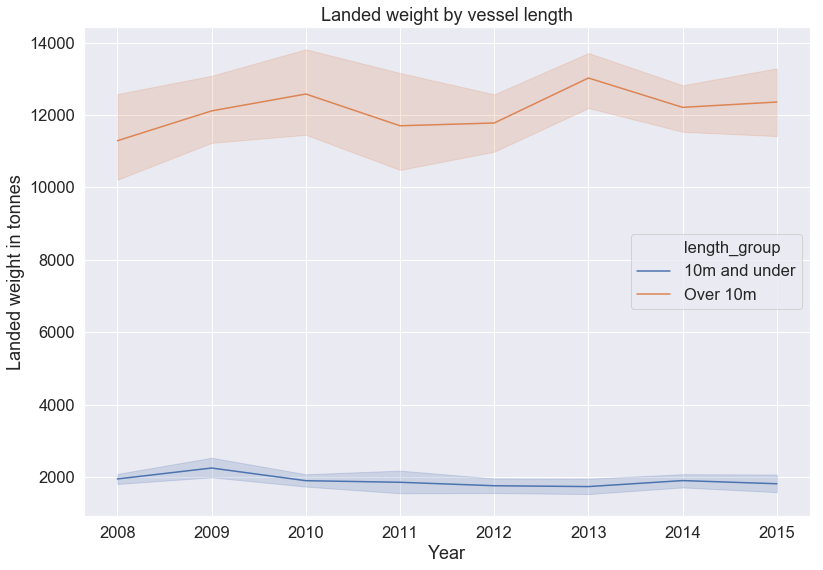

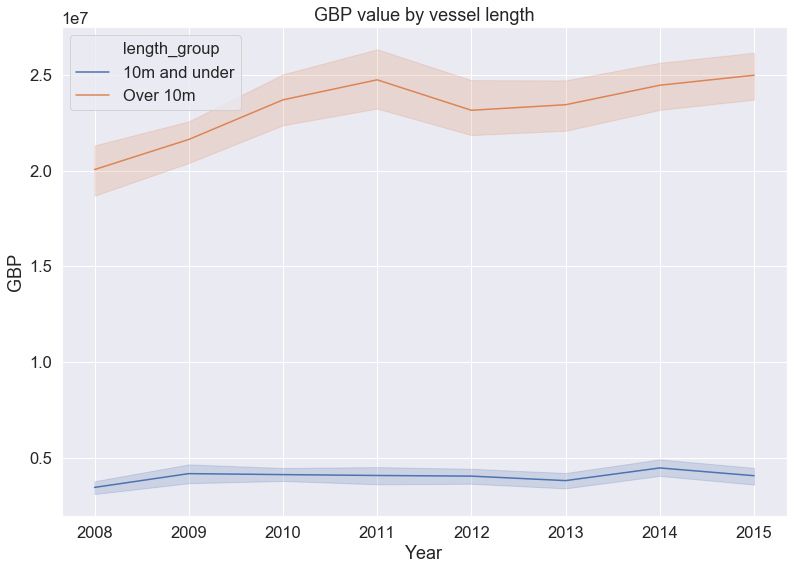

In [658]:
plt.figure(figsize=(LARGE_CHART))
plt.title("Landed weight by vessel length")
ax = sns.lineplot(x="year", y="landed_weight", data=df_a, hue="length_group")
ax.set(xlabel="Year")
ax.set(ylabel="Landed weight in tonnes")
plt.show()

plt.figure(figsize=(LARGE_CHART))
plt.title("GBP value by vessel length")
ax = sns.lineplot(x="year", y="value_gbp", data=df_a, hue="length_group")
ax.set(xlabel="Year")
ax.set(ylabel="GBP")
plt.show()

These plots show a clear gap between larger and smaller vessels. Per year, larger vessels tend to catch 10,000 - 14,000 tonnes of demersal fish, while smaller vessel catch around 2,000 tonnes. A slight upwards trend can be seen in the larger vessel curve, while the smaller vessel curve seems to drop ever so slighty. This could be a coincidence or an indication that either more larger vessels are involved in comercial fishing or that they land greater catches. This also matches the GBP value curve. Large vessel catches per year are clearly increasing in value (which could partly be because of inflation), whereas smaller vessel catches are not subject to the same growth.

### Demersal catches per month per year

For this analysis, we want to look at how much demersal fish was caught per month per year. To visualise correlations we will generate heatmaps, one for smaller vessel and one for larger vessel catches.

In [659]:
small_vessel_data = df[df.length_group == "10m and under"]
large_vessel_data = df[df.length_group == "Over 10m"]

def display_heatmap(data, subject):
    df_temp = data[["year", "month", subject]]
    df_temp = df_temp.groupby(["year", "month"], as_index=False).sum() # summarizes values per month per year
    pivoted = df_temp.pivot(index="month", columns="year", values=subject) # required shape for heatmap
    plt.figure(figsize=(LARGE_CHART))
    sns.heatmap(data=pivoted, annot=True, annot_kws={"size": 10}, fmt="g", linewidths=.5, cmap="viridis")

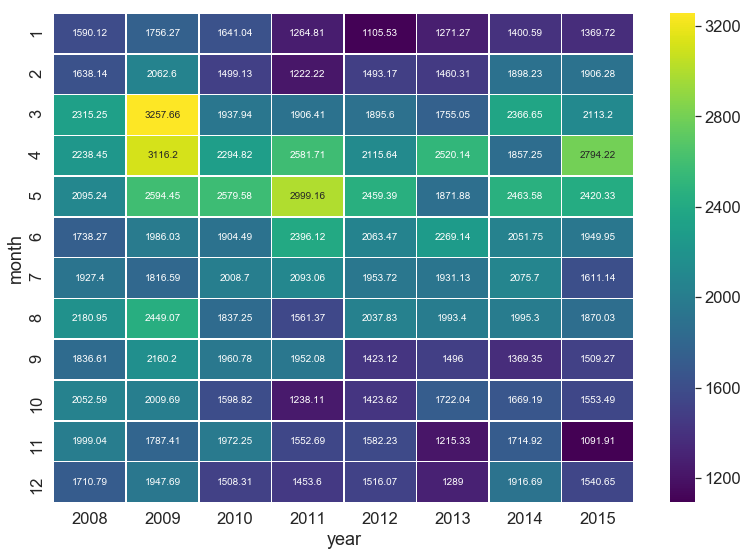

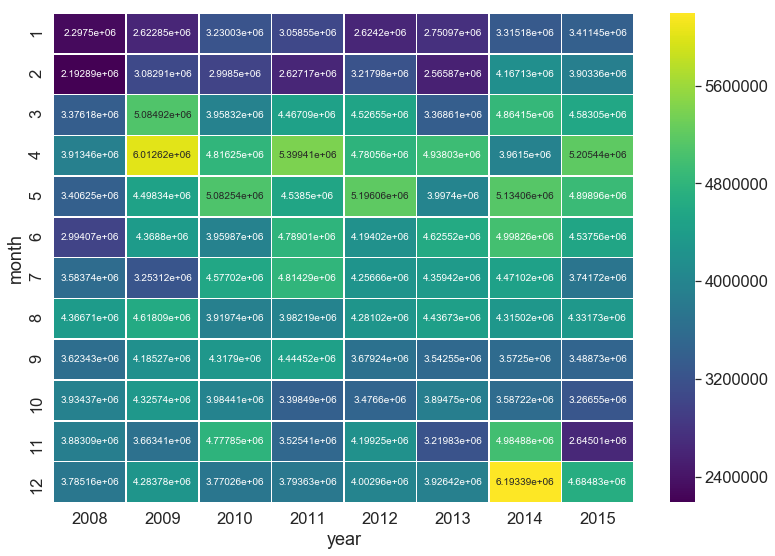

In [660]:
display_heatmap(small_vessel_data, "landed_weight")
display_heatmap(small_vessel_data, "value_gbp")

By interpreting the heatmaps for small vessel data we can make a number of observations:

* Most demersal fish are caught during spring. During colder seasons, the reported catches are smaller compared to catches of warmer seasons. Since less fish is caught, the value of the catches is lower during as well. However, this is not as distinct for the months of October, November and December. Although small vessels are catching relativeley little fish during these months, the GBP value does not decrease with the same magnitude.
* An unusual amount of demersal fish was caught in March and April of 2009 and in May 2011. In April 2009, the GBP value was unusually high as well, which fits the landed weight value.
* In December 2014 the GBP value was unusally high which does not match the landed weight value.
* The amount of demersal fish caught by vessels under 10m seems to have dropped from 2008 to 2015. The decline in GBP value is almost miniscule but still visible.

Following are the heatmaps for large vessel data.

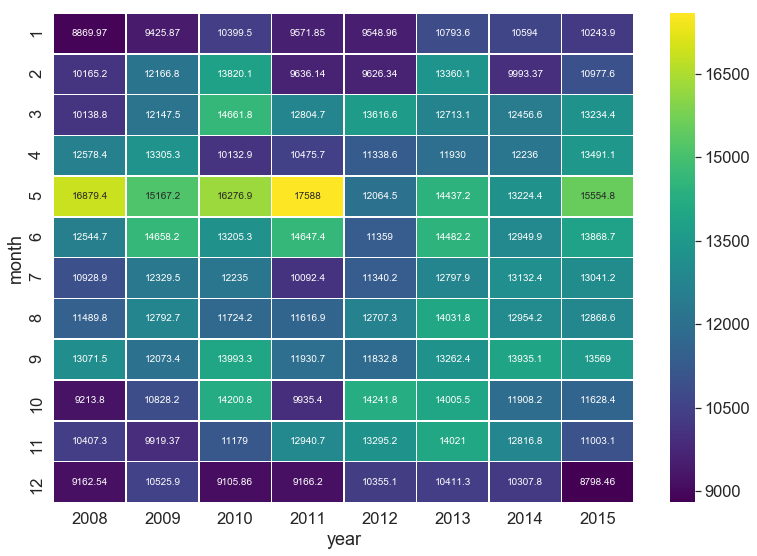

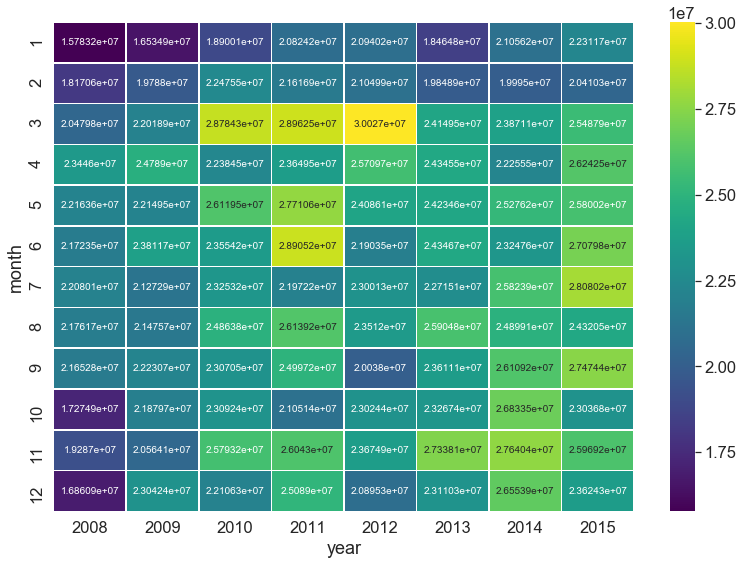

In [661]:
display_heatmap(large_vessel_data, "landed_weight")
display_heatmap(large_vessel_data, "value_gbp")

We can make similar observations for large vessel catches and compare these to the previous heatmaps:

* Again, during colder seasons, the reported catches were smaller compared to catches of warmer seasons and the GBP value does not decrease accordingly.
* An unusual amount of demersal fish was caught in May of 2008, 2010 and 2011. The GBP value was unusually high in March of 2010, 2011 and 2012 and again in June 2011. There is just a partial match or correlation between landed weight and GBP value as well.
* The amount of demersal fish caught by vessels longer than 10m seems to have risen from 2008 to 2015, as well as the GBL value.

It would be interesting to explore what caused the mentioned unusual weights of demersal catches and especially why they are only partially correlated. Another question is why generally less fish is caught during colder seasons. This could have a number of reasons, for example fishing regulations, species migration or market demand. It could also be coincidental. Furthermore, our observations suggest that fishing vessels either tend to get larger or that less smaller vessels are involved in commercial fishing, which is an interesting point to research further.

## Landed weight vs. GBP value

For this part of the data analysis, the vessel nationalities are included in the data set again. We now want to take a closer look at the relationship between the landed weight and the monetary value of demersal catches. We will first check if there are any data "oddities", i.e. where `value_gbp` is equal to zero but `landed_weight` is not, or were `value_gbp` is not equal to zero but `landed_weight` is.

In [662]:
x = df.loc[(df.value_gbp == 0) & (df.landed_weight > 0)]
print("Number of entries where 'value_gbp' is 0 but 'landed_weight' is not:", x.shape[0])

y = df.loc[(df.value_gbp > 0) & (df.landed_weight == 0)]
print("Number of entries where 'value_gbp' is not 0 but 'landed_weight' is:", y.shape[0])

Number of entries where 'value_gbp' is 0 but 'landed_weight' is not: 32
Number of entries where 'value_gbp' is not 0 but 'landed_weight' is: 0


We would assume that every successful catch is sold or valued for at least some amount on landing. The given data and the original data source sadly do not explain why some catches have a value of 0 GBP. It could be possible that the data is faulty or the catch is devalued for some reason. We can take a closer look at the 32 entries.

In [663]:
x

,index,year,month,vessel_nationality,species_group,length_group,landed_weight,value_gbp
186,186,2008,9,Denmark,Demersal,10m and under,2.000,0.0
730,730,2010,9,Denmark,Demersal,10m and under,2.000,0.0
1216,1216,2012,7,UK - Jersey,Demersal,Over 10m,0.420,0.0
1240,1240,2012,8,UK - Jersey,Demersal,Over 10m,1.977,0.0
1309,1309,2012,11,UK - Jersey,Demersal,Over 10m,0.042,0.0
1362,1362,2013,2,Belgium,Demersal,10m and under,6.328,0.0
1540,1540,2013,10,Netherlands,Demersal,Over 10m,6.793,0.0
1553,1553,2013,11,Belgium,Demersal,10m and under,11.736,0.0
1560,1560,2013,11,Netherlands,Demersal,10m and under,9.431,0.0
1574,1574,2013,12,Belgium,Demersal,10m and under,24.819,0.0


Most of the entries are noted in 2014 and 2015 by vessels with a nationality of "UK Jersey", "UK Isle of Man" and "Belgium" but do not seem to be related otherwise.

Because we want to explore the relationship between landed weight and monetary value we will remove these values from the data set since they are potentially faulty.

In [664]:
df.drop(x.index, inplace=True)

### Plotting polynomal regression

With the help of a seaborn `regplot` we can examine the relationship between `landed_weight` and `value_gbp` values. Using the `numpy` implementation of least squares polynomial fit, an approximated underlying curve is plotted.

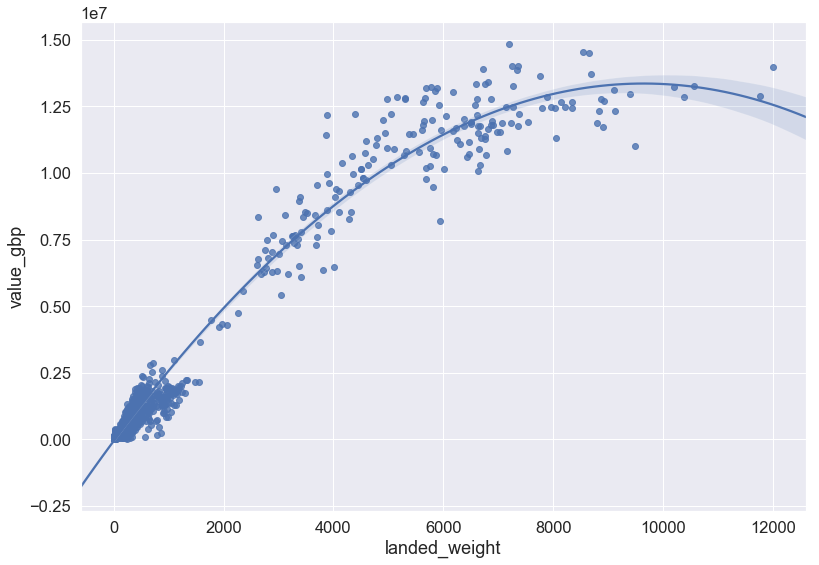

In [665]:
plt.figure(figsize=(LARGE_CHART))
sns.regplot(x="landed_weight", y="value_gbp", data=df, order=2)

The first half of the curve is almost linear. This illustrates that the value of a catch is proportional to it's weight with a slightly declining slope. We can say that the heavier a catch, the more valuable it is. However, after a weight of around 7,000 tonnes the slope of the curve starts to decline rapidly, resulting in the prediction of a negative slope for catches with a landed weight higher than 10,000 tonnes. This suggest that the market demand for demersal fish is satisfied at yearly amount of around 9,000 tonnes since the turnover drops for higher values.

### Cluster analysis

With cluster analysis algorithms like K-Means it is possible to identify groups or clusters of data which can expose hidden connections. We will apply K-Means to our data set by combining `landed_weight` and `value_gbp` values as features and experimentally set the number of expected clusters to 1, 2, 3, 4 and 10.

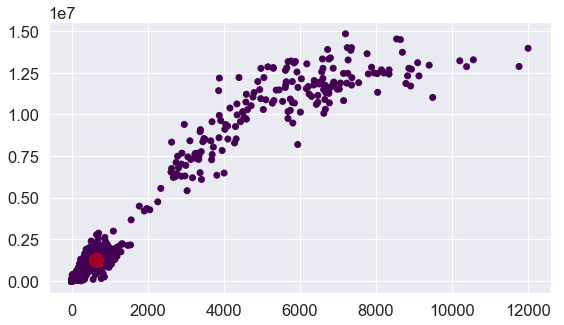

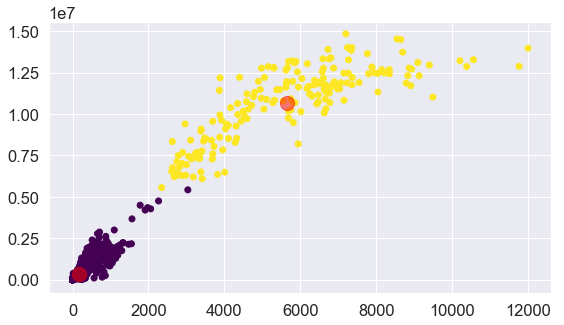

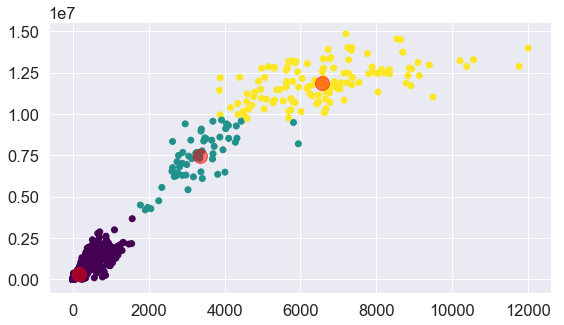

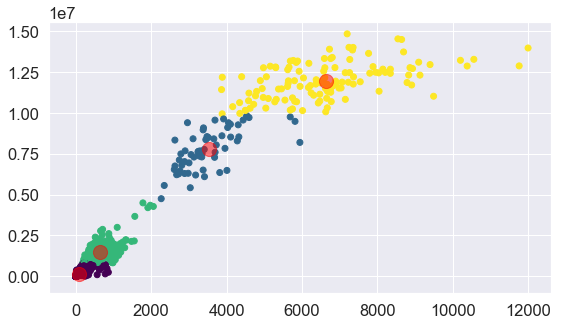

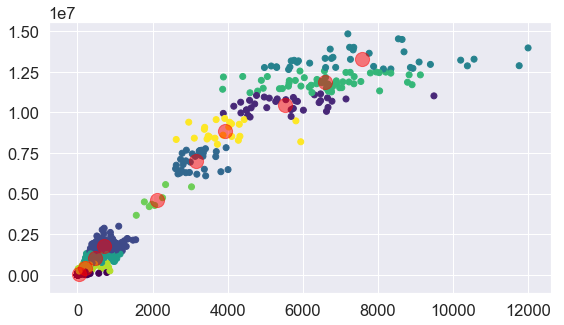

In [666]:
f1 = df.landed_weight
f2 = df.value_gbp
X = np.column_stack((f1,f2))

def analyse_kmeans(clusters):
    kmeans = KMeans(clusters)
    kmeans.fit(X)
    y_kmeans = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_

    plt.figure(figsize=(SMALL_CHART))
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap="viridis")
    plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha=0.5, c="red");

analyse_kmeans(1)
analyse_kmeans(2)
analyse_kmeans(3)
analyse_kmeans(4)
analyse_kmeans(10)

We can see that there are no clear data clusters because when increasing the number of expected clusters, the data points appear to be separated into groups of even value ranges of the y-axis. For example, the ranges for three expected clusters are around [0, 0.4], [0.4, 1] and [1, 1.5]. The respective cluster centroids seem to be located on the already predicted polynomal regression curve. In this case, cluster analysis does not provide new insights into the data.

### GBP value of demersal catches by vessel nationality per year

Next, we want to include vessel nationalities into our analysis. We will identify the top contributors by summing up the GBP value of each nationality throughout the years of 2008-2015 and sorting the results descendingly. This will be visualised in a simple bar plot.

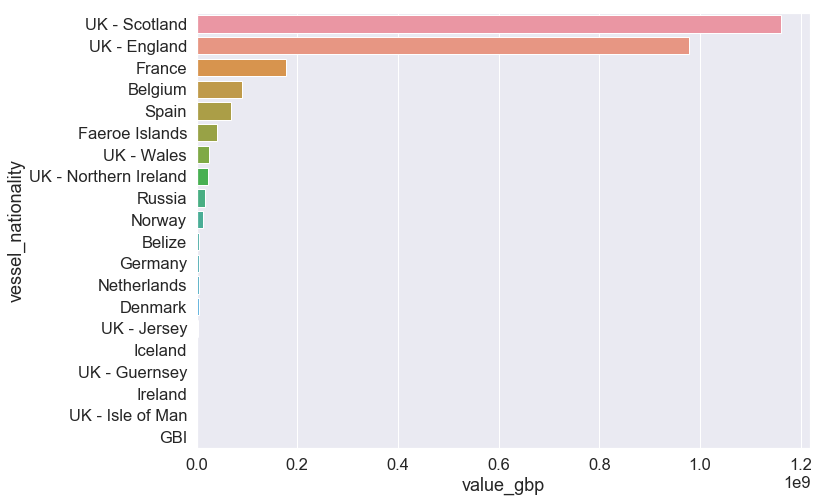

In [667]:
df_b = df.groupby(["vessel_nationality"], as_index=False).sum()

sorted = df_b.sort_values(by="value_gbp", ascending=False)
plt.figure(figsize=MEDIUM_CHART)
sns.barplot(x="value_gbp", y="vessel_nationality", data=sorted)

As we previously suspected, vessels of Scottish and English nationality are the top contributors for commercial fishing in the UK. The gap between the following countries like France, Belgium and Spain, is rather large.

We can investigate how the demersal catches turnout for each nationality is changing throug the years by plotting them side by side. Since the list is rather long, we will limit the list to the top nine contributors. In the following line plots

In [668]:
top_nine = pd.unique(sorted[["vessel_nationality"]].values.ravel("K"))[:9]
print("Top nine nationalities:")
top_nine

Top nine nationalities:


array(['UK - Scotland', 'UK - England', 'France', 'Belgium', 'Spain',
       'Faeroe Islands', 'UK - Wales', 'UK - Northern Ireland', 'Russia'],
      dtype=object)

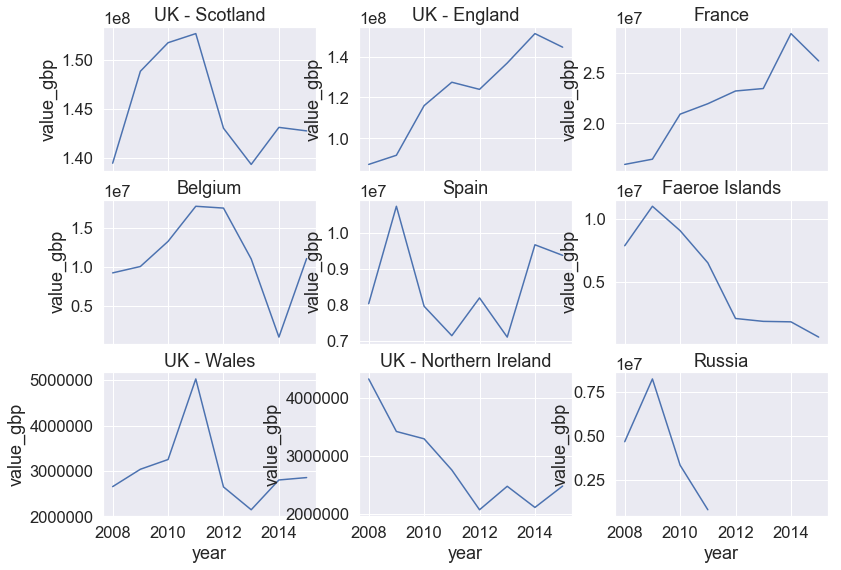

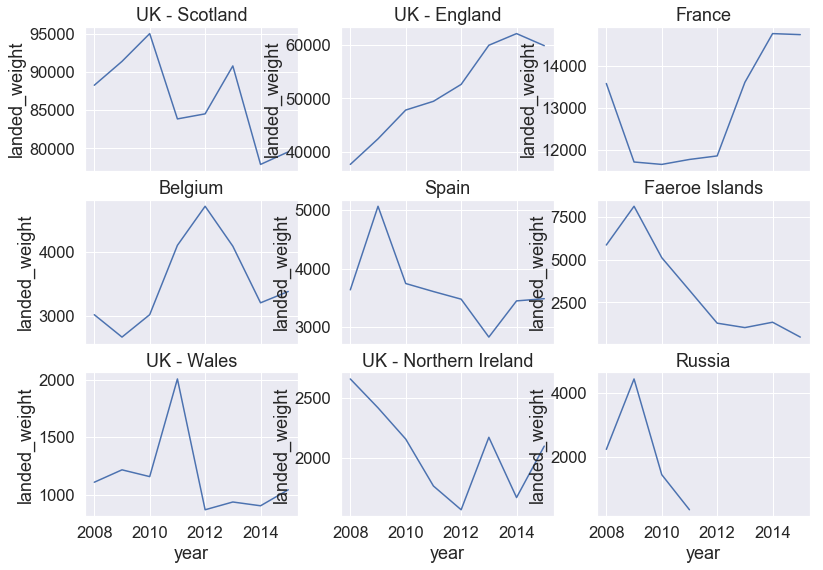

In [669]:
df_temp = df.groupby(["year", "vessel_nationality"], as_index=False).sum()

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=LARGE_CHART)
nationalities = {
    'UK - Scotland': axes[0,0],
    'UK - England': axes[0,1],
    'France': axes[0,2],
    'Belgium': axes[1,0],
    'Spain': axes[1,1],
    'Faeroe Islands': axes[1,2],
    'UK - Wales': axes[2,0],
    'UK - Northern Ireland': axes[2,1],
    'Russia': axes[2,2]
}
for nat, ax in nationalities.items():
    ax.set_title(nat)
    dfx = df_temp[df_temp.vessel_nationality == nat]
    sns.lineplot(x="year", y="value_gbp", data=dfx, ax=ax)

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=LARGE_CHART)
nationalities = {
    'UK - Scotland': axes[0,0],
    'UK - England': axes[0,1],
    'France': axes[0,2],
    'Belgium': axes[1,0],
    'Spain': axes[1,1],
    'Faeroe Islands': axes[1,2],
    'UK - Wales': axes[2,0],
    'UK - Northern Ireland': axes[2,1],
    'Russia': axes[2,2]
}
df_temp = df.groupby(["year", "vessel_nationality"], as_index=False).sum()
for nat, ax in nationalities.items():
    ax.set_title(nat)
    dfx = df_temp[df_temp.vessel_nationality == nat]
    sns.lineplot(x="year", y="landed_weight", data=dfx, ax=ax)

It appears that the involvement into UK commercial fishing is dropping for most of the displayed nationalities, namely Scotland, Faeroe Islands, Wales, Northern Ireland and Russia. In contrast, the involvement of England and France is rising steadily. The shape of the lines for `landed_weight` and `value_gbp` are matching for each respective nationality, with the exception of the France, where the line for GBP value is rising while the line for landed weight is falling. The lines for Scotland are noticable as well, since there is a relatively low value for GBP value compared to a relatively high landed weight value in 2013.

Finally, we will use a seaborn `regplot` to fit a curve into each nationalities values via linear regression.

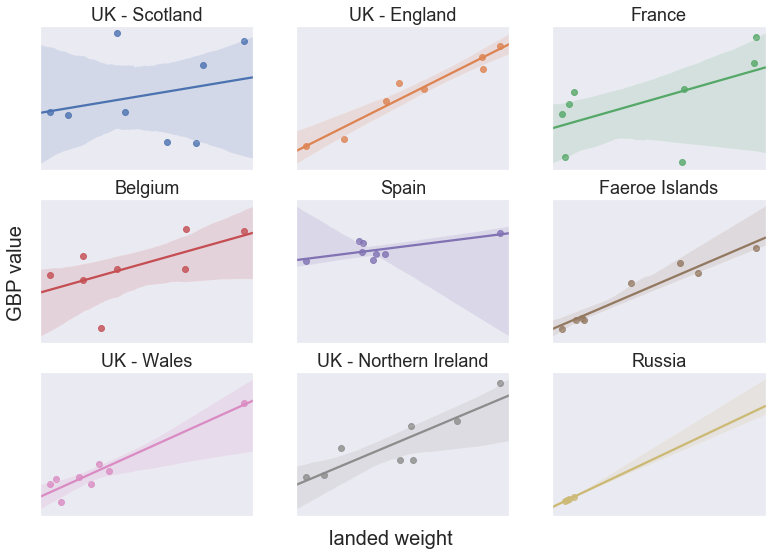

In [670]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=LARGE_CHART)
fig.text(0.5, 0.09, "landed weight", ha="center", va="center", fontsize=20)
fig.text(0.1, 0.5, "GBP value", ha="center", va="center", rotation="vertical", fontsize=20)

nationalities = {
    'UK - Scotland': axes[0,0],
    'UK - England': axes[0,1],
    'France': axes[0,2],
    'Belgium': axes[1,0],
    'Spain': axes[1,1],
    'Faeroe Islands': axes[1,2],
    'UK - Wales': axes[2,0],
    'UK - Northern Ireland': axes[2,1],
    'Russia': axes[2,2]
}

df_temp = df.groupby(["year", "vessel_nationality"], as_index=False).sum()

for nat, ax in nationalities.items():
    dfx = df_temp[df_temp.vessel_nationality == nat]
    ax.set_title(nat)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    sns.regplot(x="landed_weight", y="value_gbp", data=dfx, ax=ax, order=1)

Matching the described discrepancies of the values for Scotland and France, the error range around the fitted curve covers a respectively large area. The correlation between landed weight and GBP value seems to match our previous observations that a greater catch means a greater value. However, this does not seem to be the case for Scotland and Spain, since the slope of the curve is comparatively low. There are also a few outliers for France and Belgium. Furthermore, if we consider that England and Scotland the two main contributor to UK commercial fishing, it is noticeable that their respective curves are so different. This could mean that Scottish catches are valued differently than English catches and potentially valued at lower rates, since the slope of the Scottish curve is lower.